# NB04: Functional Enrichment & Module Analysis

Test H1c/H1d:
- Are metal-specific genes enriched for known metal resistance functions?
- Are the 149 novel candidates disproportionately metal-specific?
- ICA module specificity analysis: which modules are metal-specific?

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

PROJ = os.path.abspath('..')
MAIN_REPO = '/home/psdehal/pangenome_science/BERIL-research-observatory'
METAL_ATLAS = os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data')
ESSENTIAL = os.path.join(MAIN_REPO, 'projects', 'essential_genome', 'data')
FITNESS_MOD = os.path.join(MAIN_REPO, 'projects', 'fitness_modules', 'data')
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')

## Load data

In [2]:
# Gene specificity
spec = pd.read_csv(os.path.join(DATA_OUT, 'gene_specificity_classification.csv'))
print(f'Gene specificity records: {len(spec)}')

# Ortholog groups
og = pd.read_csv(os.path.join(ESSENTIAL, 'all_ortholog_groups.csv'))
print(f'Ortholog group assignments: {len(og)}')

# SEED annotations
seed_file = os.path.join(ESSENTIAL, 'all_seed_annotations.tsv')
if os.path.exists(seed_file):
    seed = pd.read_csv(seed_file, sep='\t')
    print(f'SEED annotations: {len(seed)}')
else:
    seed = None
    print('SEED annotations: not found')

# Novel candidates from atlas
novel = pd.read_csv(os.path.join(METAL_ATLAS, 'novel_metal_candidates.csv'))
print(f'Novel metal candidates: {len(novel)}')

# Conserved families from atlas
conserved = pd.read_csv(os.path.join(METAL_ATLAS, 'conserved_metal_families.csv'))
print(f'Conserved metal families: {len(conserved)}')

Gene specificity records: 6838
Ortholog group assignments: 179237


SEED annotations: 177519
Novel metal candidates: 149
Conserved metal families: 1182


## Map specificity to ortholog groups and annotations

In [3]:
# Join specificity with OG assignments
spec_og = spec.merge(og[['orgId', 'locusId', 'OG_id']], on=['orgId', 'locusId'], how='left')
print(f'Genes with OG assignments: {spec_og["OG_id"].notna().sum()} / {len(spec_og)}')

# Join with SEED annotations
if seed is not None:
    # Identify the right columns
    seed_cols = seed.columns.tolist()
    print(f'SEED columns: {seed_cols[:10]}')
    
    # Try to find orgId/locusId columns
    org_col = [c for c in seed_cols if c.lower() in ['orgid', 'org_id', 'organism']]
    locus_col = [c for c in seed_cols if c.lower() in ['locusid', 'locus_id', 'locus', 'gene']]
    desc_col = [c for c in seed_cols if 'desc' in c.lower() or 'annotation' in c.lower() or 'seed' in c.lower()]
    
    if org_col and locus_col and desc_col:
        seed_sub = seed[[org_col[0], locus_col[0], desc_col[0]]].copy()
        seed_sub.columns = ['orgId', 'locusId', 'seed_description']
        spec_og = spec_og.merge(seed_sub, on=['orgId', 'locusId'], how='left')
        print(f'Genes with SEED annotations: {spec_og["seed_description"].notna().sum()}')
    else:
        print(f'Could not match SEED columns: org={org_col}, locus={locus_col}, desc={desc_col}')
        spec_og['seed_description'] = np.nan
else:
    spec_og['seed_description'] = np.nan

Genes with OG assignments: 5728 / 6838
SEED columns: ['orgId', 'locusId', 'seed_desc']
Genes with SEED annotations: 5735


## Functional keyword enrichment

In [4]:
# Metal resistance keywords
METAL_RESISTANCE_KEYWORDS = [
    'efflux', 'transporter', 'metal', 'pump', 'CDF', 'P-type ATPase',
    'siderophore', 'iron', 'copper', 'zinc', 'cobalt', 'nickel',
    'czc', 'cus', 'cop', 'znt', 'nik', 'cor', 'mercury', 'arsenic',
    'heavy metal', 'metal-binding', 'metallochaperone', 'metal resistance',
    'ABC transporter', 'RND', 'MFS',
]

GENERAL_STRESS_KEYWORDS = [
    'DNA repair', 'recombination', 'cell wall', 'cell envelope', 'peptidoglycan',
    'lipopolysaccharide', 'LPS', 'membrane', 'ribosom', 'chaperone',
    'protease', 'heat shock', 'cold shock', 'sigma', 'response regulator',
    'two-component', 'signal transduction',
]

def count_keyword_hits(descriptions, keywords):
    """Count fraction of descriptions matching any keyword."""
    descriptions = descriptions.dropna().str.lower()
    hits = 0
    for desc in descriptions:
        for kw in keywords:
            if kw.lower() in desc:
                hits += 1
                break
    return hits, len(descriptions)

# Compare keyword enrichment across categories
print('=== Functional keyword enrichment by specificity ===')
print(f'{"Category":20s} | {"Metal-resistance":>18s} | {"General-stress":>16s} | {"N annotations":>14s}')
print('-' * 80)

for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
    sub = spec_og[spec_og.specificity_5pct == cat]
    descs = sub['seed_description']
    
    mr_hits, mr_n = count_keyword_hits(descs, METAL_RESISTANCE_KEYWORDS)
    gs_hits, gs_n = count_keyword_hits(descs, GENERAL_STRESS_KEYWORDS)
    
    mr_pct = 100 * mr_hits / mr_n if mr_n > 0 else 0
    gs_pct = 100 * gs_hits / gs_n if gs_n > 0 else 0
    
    print(f'{cat:20s} | {mr_hits:5d}/{mr_n:5d} ({mr_pct:5.1f}%) | {gs_hits:5d}/{gs_n:5d} ({gs_pct:5.1f}%) | {descs.notna().sum():14d}')

# Fisher exact test: metal-resistance keywords in metal-specific vs general-sick
ms_descs = spec_og[spec_og.specificity_5pct == 'metal_specific']['seed_description']
gs_descs = spec_og[spec_og.specificity_5pct == 'general_sick']['seed_description']
ms_mr, ms_n = count_keyword_hits(ms_descs, METAL_RESISTANCE_KEYWORDS)
gs_mr, gs_n = count_keyword_hits(gs_descs, METAL_RESISTANCE_KEYWORDS)

table = [[ms_mr, ms_n - ms_mr], [gs_mr, gs_n - gs_mr]]
odds, p = stats.fisher_exact(table)
print(f'\nFisher exact (metal-resistance keywords: metal-specific vs general-sick):')
print(f'  OR={odds:.2f}, p={p:.2e}')

=== Functional keyword enrichment by specificity ===
Category             |   Metal-resistance |   General-stress |  N annotations
--------------------------------------------------------------------------------
metal_specific       |   372/ 2928 ( 12.7%) |   405/ 2928 ( 13.8%) |           2928
metal_plus_stress    |    39/  477 (  8.2%) |    31/  477 (  6.5%) |            477
general_sick         |   190/ 2330 (  8.2%) |   273/ 2330 ( 11.7%) |           2330

Fisher exact (metal-resistance keywords: metal-specific vs general-sick):
  OR=1.64, p=1.04e-07


## H1d: Are the 149 novel candidates metal-specific?

In [5]:
# Map novel candidates to specificity via OG assignments
novel_ogs = set(novel['OG_id'].unique())
spec_with_og = spec_og[spec_og.OG_id.notna()].copy()

# For each OG, get the dominant specificity (majority vote across member genes)
og_specificity = spec_with_og.groupby('OG_id')['specificity_5pct'].agg(
    lambda x: x.value_counts().index[0]  # most common category
).reset_index()
og_specificity.columns = ['OG_id', 'dominant_specificity']

# Also compute fraction metal-specific per OG
og_spec_frac = spec_with_og.groupby('OG_id').apply(
    lambda x: pd.Series({
        'n_genes': len(x),
        'n_metal_specific': (x.specificity_5pct == 'metal_specific').sum(),
        'frac_metal_specific': (x.specificity_5pct == 'metal_specific').mean(),
        'mean_sick_rate': x['sick_rate_nonmetal'].mean(),
    })
).reset_index()

og_spec_frac = og_spec_frac.merge(og_specificity, on='OG_id')

# Compare novel vs annotated families
og_spec_frac['is_novel'] = og_spec_frac['OG_id'].isin(novel_ogs)

print('=== Novel vs Annotated OG families ===')
for label, is_novel in [('Novel (149)', True), ('Annotated (rest)', False)]:
    sub = og_spec_frac[og_spec_frac.is_novel == is_novel]
    if len(sub) == 0:
        continue
    n_ms = (sub.dominant_specificity == 'metal_specific').sum()
    pct_ms = 100 * n_ms / len(sub)
    mean_frac = sub['frac_metal_specific'].mean()
    print(f'  {label:25s}: {n_ms:4d} / {len(sub):4d} metal-specific ({pct_ms:.1f}%), '
          f'mean frac={mean_frac:.3f}')

# Fisher exact: are novel OGs more likely to be metal-specific?
nov = og_spec_frac[og_spec_frac.is_novel]
ann = og_spec_frac[~og_spec_frac.is_novel]
if len(nov) > 0 and len(ann) > 0:
    a = (nov.dominant_specificity == 'metal_specific').sum()
    b = len(nov) - a
    c = (ann.dominant_specificity == 'metal_specific').sum()
    d = len(ann) - c
    odds, p = stats.fisher_exact([[a, b], [c, d]])
    print(f'\n  Fisher exact (novel vs annotated metal-specificity): OR={odds:.2f}, p={p:.3f}')

=== Novel vs Annotated OG families ===
  Novel (149)              :   67 /  149 metal-specific (45.0%), mean frac=0.442
  Annotated (rest)         : 1395 / 2484 metal-specific (56.2%), mean frac=0.559

  Fisher exact (novel vs annotated metal-specificity): OR=0.64, p=0.008


In [6]:
# Check top IP candidates specifically
top_candidates = {
    'OG01383': 'YebC (11 orgs, 6 metals)',
    'OG00391': 'YfdZ (7 orgs, 9 metals)',
    'OG02094': 'UPF0042/RapZ (8 orgs, 7 metals)',
    'OG02233': 'YrbC (8 orgs, 4 metals)',
    'OG03534': 'YrbE (6 orgs, 5 metals)',
    'OG04003': 'MlaD (4 orgs, 4 metals)',
    'OG03264': 'DUF1043/YhcB (6 orgs, 5 metals)',
    'OG08209': 'DUF39 (2 orgs, 8 metals)',
    'OG01015': 'UCP030820 (3 orgs, 7 metals)',
}

print('=== Top Novel Candidate Specificity ===')
print(f'{"OG":10s} | {"Name":35s} | {"N genes":>7s} | {"Metal-spec":>10s} | {"Frac":>6s} | {"Mean sick_rate":>14s}')
print('-' * 95)

for og_id, name in top_candidates.items():
    og_data = spec_with_og[spec_with_og.OG_id == og_id]
    if len(og_data) > 0:
        n = len(og_data)
        n_ms = (og_data.specificity_5pct == 'metal_specific').sum()
        frac = n_ms / n
        mean_sr = og_data['sick_rate_nonmetal'].mean()
        print(f'{og_id:10s} | {name:35s} | {n:7d} | {n_ms:10d} | {frac:6.2f} | {mean_sr:14.4f}')
    else:
        print(f'{og_id:10s} | {name:35s} | no data')

=== Top Novel Candidate Specificity ===
OG         | Name                                | N genes | Metal-spec |   Frac | Mean sick_rate
-----------------------------------------------------------------------------------------------
OG01383    | YebC (11 orgs, 6 metals)            |      11 |          7 |   0.64 |         0.0553
OG00391    | YfdZ (7 orgs, 9 metals)             |       7 |          1 |   0.14 |         0.2668
OG02094    | UPF0042/RapZ (8 orgs, 7 metals)     |       7 |          2 |   0.29 |         0.1301
OG02233    | YrbC (8 orgs, 4 metals)             |       9 |          1 |   0.11 |         0.2339
OG03534    | YrbE (6 orgs, 5 metals)             |       6 |          0 |   0.00 |         0.1903
OG04003    | MlaD (4 orgs, 4 metals)             |       4 |          1 |   0.25 |         0.1126
OG03264    | DUF1043/YhcB (6 orgs, 5 metals)     |       6 |          3 |   0.50 |         0.0539
OG08209    | DUF39 (2 orgs, 8 metals)            |       1 |          0 |   0.00

## ICA Module Specificity Analysis

In [7]:
# Load metal module data from the atlas
metal_modules = pd.read_csv(os.path.join(METAL_ATLAS, 'metal_modules.csv'))
print(f'Metal module records: {len(metal_modules)}')
print(f'Columns: {metal_modules.columns.tolist()[:10]}')

# Load experiment classification
exp_class = pd.read_csv(os.path.join(DATA_OUT, 'experiment_classification.csv'))

# For each organism with ICA modules, load module condition activity
module_files = sorted(glob.glob(os.path.join(FITNESS_MOD, 'modules', '*_module_conditions.csv')))
print(f'Module condition files: {len(module_files)}')
if module_files:
    print(f'Example: {os.path.basename(module_files[0])}')

Metal module records: 19453
Columns: ['orgId', 'module_id', 'expName', 'metal_element', 'raw_activity', 'z_score', 'is_responsive']
Module condition files: 32
Example: ANA3_module_conditions.csv


In [8]:
# Compute module-level metal specificity
# For each module, compare its activity under metal vs non-metal experiments
module_specificity_results = []

for mod_file in module_files:
    org = os.path.basename(mod_file).replace('_module_conditions.csv', '')
    org_exps = exp_class[exp_class.orgId == org]
    
    if len(org_exps) == 0:
        continue
    
    try:
        mod_cond = pd.read_csv(mod_file, index_col=0)
    except Exception:
        continue
    
    # Map experiments to metal/non-metal
    metal_exps_set = set(org_exps[org_exps.stress_category == 'metal']['expName'])
    nonmetal_exps_set = set(org_exps[org_exps.stress_category != 'metal']['expName'])
    
    available = set(mod_cond.columns)
    metal_cols = [e for e in metal_exps_set if e in available]
    nonmetal_cols = [e for e in nonmetal_exps_set if e in available]
    
    if not metal_cols or not nonmetal_cols:
        continue
    
    for module_id in mod_cond.index:
        metal_vals = mod_cond.loc[module_id, metal_cols].astype(float).values
        nonmetal_vals = mod_cond.loc[module_id, nonmetal_cols].astype(float).values
        
        # Z-score the activity across ALL experiments for this module
        all_vals = np.concatenate([metal_vals, nonmetal_vals])
        if np.std(all_vals) == 0:
            continue
        z_metal = (metal_vals - np.mean(all_vals)) / np.std(all_vals)
        z_nonmetal = (nonmetal_vals - np.mean(all_vals)) / np.std(all_vals)
        
        # Metal specificity score: max |z| under metal minus max |z| under non-metal
        max_z_metal = np.max(np.abs(z_metal))
        max_z_nonmetal = np.max(np.abs(z_nonmetal))
        
        # Count responsive experiments (|z| > 2)
        n_responsive_metal = np.sum(np.abs(z_metal) > 2)
        n_responsive_nonmetal = np.sum(np.abs(z_nonmetal) > 2)
        
        # Metal-specific module: responsive under metals but not non-metals
        is_metal_responsive = n_responsive_metal > 0
        is_nonmetal_responsive = n_responsive_nonmetal > 0
        
        if is_metal_responsive:
            if not is_nonmetal_responsive:
                module_class = 'metal_specific_module'
            else:
                module_class = 'shared_response_module'
        else:
            continue  # Not metal-responsive at all
        
        module_specificity_results.append({
            'orgId': org,
            'module_id': module_id,
            'n_metal_exps': len(metal_cols),
            'n_nonmetal_exps': len(nonmetal_cols),
            'n_responsive_metal': n_responsive_metal,
            'n_responsive_nonmetal': n_responsive_nonmetal,
            'max_z_metal': max_z_metal,
            'max_z_nonmetal': max_z_nonmetal,
            'specificity_score': max_z_metal - max_z_nonmetal,
            'module_class': module_class,
        })

mod_spec_df = pd.DataFrame(module_specificity_results)
if len(mod_spec_df) > 0:
    print(f'Metal-responsive modules: {len(mod_spec_df)}')
    print(f'Organisms: {mod_spec_df["orgId"].nunique()}')
    print(f'\nModule classification:')
    print(mod_spec_df['module_class'].value_counts().to_string())
    
    print(f'\nMetal-specific modules (top 10 by specificity score):')
    ms_mods = mod_spec_df[mod_spec_df.module_class == 'metal_specific_module'].sort_values('specificity_score', ascending=False)
    if len(ms_mods) > 0:
        print(ms_mods[['orgId', 'module_id', 'n_responsive_metal', 'max_z_metal', 'specificity_score']].head(10).to_string(index=False))
else:
    print('No metal-responsive modules found')

No metal-responsive modules found


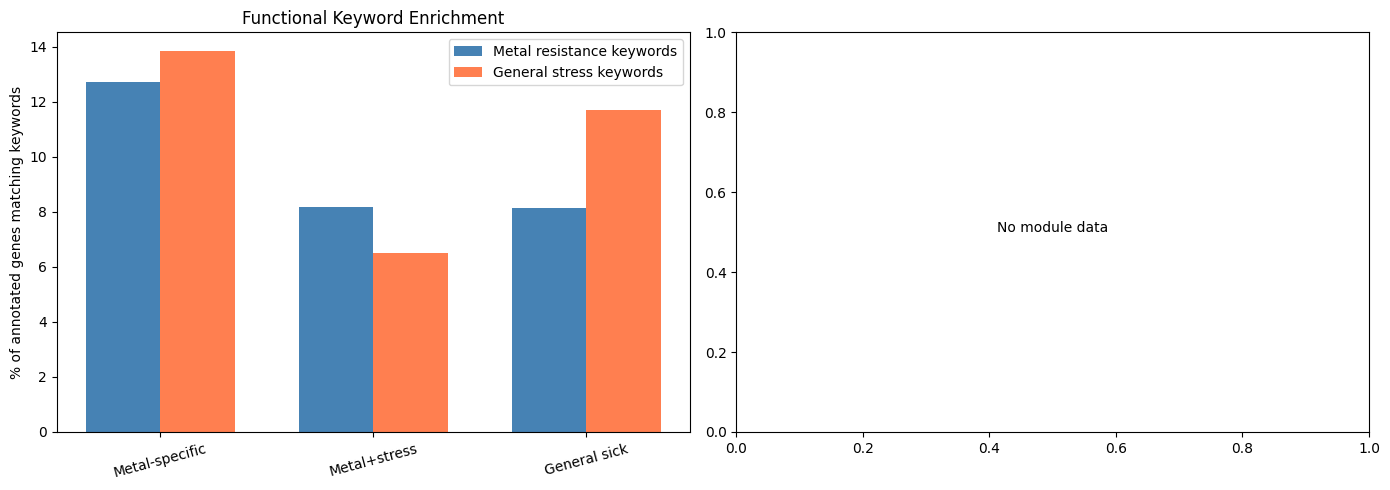

Saved: figures/functional_comparison.png


In [9]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Keyword enrichment comparison
categories = ['metal_specific', 'metal_plus_stress', 'general_sick']
cat_labels = ['Metal-specific', 'Metal+stress', 'General sick']
cat_colors = ['#2ca02c', '#ff7f0e', '#d62728']

mr_fracs = []
gs_fracs = []
for cat in categories:
    sub = spec_og[spec_og.specificity_5pct == cat]
    descs = sub['seed_description']
    mr_h, mr_n = count_keyword_hits(descs, METAL_RESISTANCE_KEYWORDS)
    gs_h, gs_n = count_keyword_hits(descs, GENERAL_STRESS_KEYWORDS)
    mr_fracs.append(100 * mr_h / mr_n if mr_n > 0 else 0)
    gs_fracs.append(100 * gs_h / gs_n if gs_n > 0 else 0)

x = np.arange(len(categories))
width = 0.35
axes[0].bar(x - width/2, mr_fracs, width, label='Metal resistance keywords', color='steelblue')
axes[0].bar(x + width/2, gs_fracs, width, label='General stress keywords', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(cat_labels, rotation=15)
axes[0].set_ylabel('% of annotated genes matching keywords')
axes[0].set_title('Functional Keyword Enrichment')
axes[0].legend()

# Panel 2: Module specificity distribution
if len(mod_spec_df) > 0:
    for cls, color, label in [('metal_specific_module', '#2ca02c', 'Metal-specific'),
                               ('shared_response_module', '#ff7f0e', 'Shared response')]:
        sub = mod_spec_df[mod_spec_df.module_class == cls]
        if len(sub) > 0:
            axes[1].hist(sub['specificity_score'], bins=20, alpha=0.6, color=color, label=label)
    axes[1].set_xlabel('Module specificity score (max |z| metal - max |z| non-metal)')
    axes[1].set_ylabel('Number of modules')
    axes[1].set_title('ICA Module Metal Specificity')
    axes[1].legend()
    axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
else:
    axes[1].text(0.5, 0.5, 'No module data', transform=axes[1].transAxes, ha='center')

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'functional_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/functional_comparison.png')

In [10]:
# Save outputs
og_spec_frac.to_csv(os.path.join(DATA_OUT, 'og_specificity.csv'), index=False)
print(f'Saved: data/og_specificity.csv ({len(og_spec_frac)} families)')

if len(mod_spec_df) > 0:
    mod_spec_df.to_csv(os.path.join(DATA_OUT, 'module_metal_specificity.csv'), index=False)
    print(f'Saved: data/module_metal_specificity.csv ({len(mod_spec_df)} modules)')

# Final summary
print(f'\n=== KEY RESULTS ===')
print(f'H1c (metal-resistance enrichment in metal-specific): OR={odds:.2f}, p={p:.2e}')

if len(nov) > 0:
    nov_ms = (nov.dominant_specificity == 'metal_specific').sum()
    nov_pct = 100 * nov_ms / len(nov)
    ann_ms = (ann.dominant_specificity == 'metal_specific').sum()
    ann_pct = 100 * ann_ms / len(ann)
    print(f'H1d (novel candidates metal-specific): {nov_pct:.1f}% vs {ann_pct:.1f}% annotated')

if len(mod_spec_df) > 0:
    n_ms_mod = (mod_spec_df.module_class == 'metal_specific_module').sum()
    pct_ms_mod = 100 * n_ms_mod / len(mod_spec_df)
    print(f'ICA modules: {n_ms_mod} / {len(mod_spec_df)} metal-specific ({pct_ms_mod:.1f}%)')

Saved: data/og_specificity.csv (2633 families)

=== KEY RESULTS ===
H1c (metal-resistance enrichment in metal-specific): OR=0.64, p=8.42e-03
H1d (novel candidates metal-specific): 45.0% vs 56.2% annotated
